In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_all = pd.read_csv("../data/TwoBarTruss.csv", delimiter=';')

In [2]:
df_all

,Volume,MaxStress,x1,x2,y,g1,Feasible
0,0.021916,18377.203009,0.002354,0.004815,2.115106,-81622.796991,1
1,0.031101,12991.022813,0.003331,0.006803,2.129376,-87008.977187,1
2,0.008704,46119.773223,0.000961,0.001948,2.022885,-53880.226777,1
3,0.038300,10514.420370,0.004061,0.008395,2.145074,-89485.579630,1
4,0.037292,10759.938300,0.004219,0.008331,1.977927,-89240.061700,1
...,...,...,...,...,...,...,...
19995,0.029792,90743.229458,0.006511,0.001055,1.523667,-9256.770542,1
19996,0.016515,29517.749139,0.001716,0.004547,1.719528,-70482.250861,1
19997,0.010111,73875.304147,0.001916,0.001476,1.079235,-26124.695853,1
19998,0.025331,62938.337736,0.004819,0.001398,2.187591,-37061.662264,1


In [63]:
variable_names = ["x1", "x2", "y"]

feasible = df_all["Feasible"].values == 1
fs = df_all[["Volume", "MaxStress"]].loc[feasible].copy().reset_index(drop=True) # to not have gaps in indices
xs = df_all[variable_names].loc[feasible].copy().reset_index(drop=True)

print(fs.head())
print(xs.head())

     Volume     MaxStress
0  0.021916  18377.203009
1  0.031101  12991.022813
2  0.008704  46119.773223
3  0.038300  10514.420370
4  0.037292  10759.938300
         x1        x2         y
0  0.002354  0.004815  2.115106
1  0.003331  0.006803  2.129376
2  0.000961  0.001948  2.022885
3  0.004061  0.008395  2.145074
4  0.004219  0.008331  1.977927


In [64]:
""" Category 1 -- Knee: MaxStress <= 50000 & Volume <= 0.02
    Category 2 -- LeftExtreme: MaxStress >= 70000 & Volume <= 0.015
    Category 3 -- Volume >= 0.055
    Category 4 -- MaxStress >= 50000 & Volume >= 0.04
"""

# Category 1
c1_mask = np.logical_and(fs["MaxStress"] <= 50000, fs["Volume"] <= 0.02)
# Category 2
c2_mask = np.logical_and(fs["MaxStress"] >= 70000, fs["Volume"] <= 0.015)
# Category 3
c3_mask = fs["Volume"] >= 0.055
# Category 4
c4_mask = np.logical_and(fs["MaxStress"] >= 50000, fs["Volume"] >= 0.04)

xs.loc[c1_mask, "category"] = 1
xs.loc[c2_mask, "category"] = 2
xs.loc[c3_mask, "category"] = 3
xs.loc[c4_mask, "category"] = 4

xs_clean = xs[~xs["category"].isnull()]
xs_clean.head()

,x1,x2,y,category
2,0.000961,0.001948,2.022885,1.0
8,0.001646,0.003333,1.957039,1.0
15,0.001044,0.002255,2.322141,1.0
20,0.001953,0.004115,2.179401,1.0
21,0.001953,0.004115,2.179401,1.0


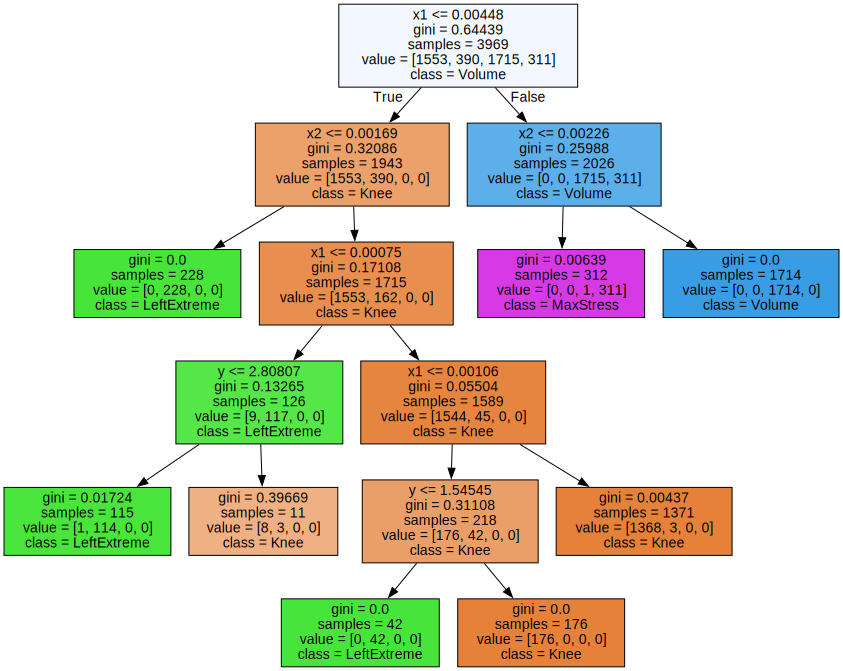

In [68]:
from sklearn import tree
Classifier = tree.DecisionTreeClassifier
from imodels.discretization import ExtraBasicDiscretizer as Discretizer
import graphviz

classifier = Classifier(max_leaf_nodes=8)
classifier.fit(xs_clean[variable_names], xs_clean["category"])

dot_data = tree.export_graphviz(classifier, out_file=None, 
                     feature_names=["x1", "x2", "y"],  
                     class_names=["Knee", "LeftExtreme", "Volume", "MaxStress"],  
                     filled=True, rounded=False, precision=5,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 